In [2]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 166.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 152.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 158.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.9 MB/s eta 0:00:00


# Ajustado


=== Entrenando CNN para PPP (5% datos) ===
Found 31802 files.
Using 25442 files for training.
Found 31802 files.
Using 6360 files for validation.
Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.0432 - loss: 3.1831 
Epoch 1: saving model to /tmp/ppp_checkpoints/cp-01.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 575s 29s/step - accuracy: 0.0433 - loss: 3.1831 - val_accuracy: 0.0346 - val_loss: 3.1817
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.0445 - loss: 3.1785 
Epoch 2: saving model to /tmp/ppp_checkpoints/cp-02.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 566s 28s/step - accuracy: 0.0445 - loss: 3.1784 - val_accuracy: 0.0440 - val_loss: 3.1775
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.0456 - loss: 3.1787 
Epoch 3: saving model to /tmp/ppp_checkpoints/cp-03.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 567s 28s/step - accuracy: 0.0456 - loss: 3.1786 - val_accuracy: 0.0220 - val_loss: 3.1798
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0

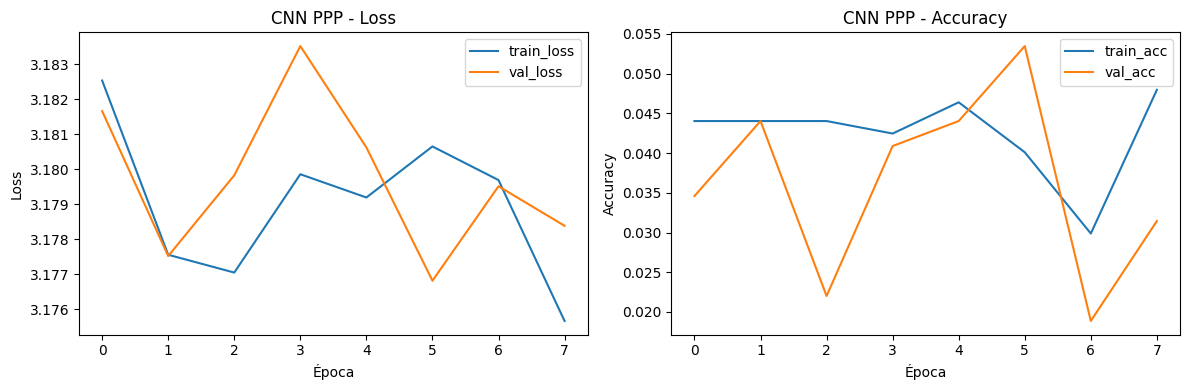

=== Entrenando ViT para PPP (5% datos) ===
Found 31802 files.
Using 25442 files for training.
Found 31802 files.
Using 6360 files for validation.


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [4]:
import tensorflow as tf
import itertools
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path

# ---------------------------------------------------------------------------
# 1.  Configuración y Hiperparámetros
# ---------------------------------------------------------------------------
@dataclass
class CFG:
    data_dir: Path = Path(
        "/content/drive/MyDrive/Procesamiento Imagenes/"
        "Taller_4_Implementrar un modelo CNN o ViT/Imagenet/imagenetood"
    )
    image_size: tuple[int, int] = (224, 224)
    patch_size: int = 16
    proj_dim: int = 48
    num_heads: int = 4
    transformer_layers: int = 4
    mlp_multiplier: int = 2
    ppp_classes: int = 24
    batch_size: int = 64
    epochs: int = 8
    seed: int = 123
    autotune: int = tf.data.AUTOTUNE
    mixed_precision: bool = True

CFG = CFG()

# Activar mixed precision si la GPU lo soporta
if CFG.mixed_precision:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Precomputar permutaciones de 4 parches (24 permutaciones)
PERMS = tf.constant(list(itertools.permutations(range(4))), dtype=tf.int32)

# ---------------------------------------------------------------------------
# 2.  Función de Transformación PPP (Patch Permutation Prediction)
# ---------------------------------------------------------------------------
@tf.function
def ppp_transform(image: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Recibe: image [224,224,3] float32 en [0,1].
    Devuelve: (scrambled_image, one_hot_label) donde scrambled_image [224,224,3].
    """
    # Extraer 4 parches de 112×112 de manera vectorizada
    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, axis=0),
        sizes=[1, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 1],
        strides=[1, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )  # shape=[1,2,2,112*112*3]
    patches = tf.reshape(patches, [4, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 3])  # (4,112,112,3)

    # Seleccionar permutación aleatoria
    idx = tf.random.uniform(shape=(), minval=0, maxval=CFG.ppp_classes, dtype=tf.int32)
    perm = PERMS[idx]                        # (4,)
    gathered = tf.gather(patches, perm)      # (4,112,112,3)

    # Reconstruir imagen scrambled
    top    = tf.concat([gathered[0], gathered[1]], axis=1)    # (112,224,3)
    bottom = tf.concat([gathered[2], gathered[3]], axis=1)    # (112,224,3)
    scrambled = tf.concat([top, bottom], axis=0)              # (224,224,3)

    # Etiqueta one-hot
    label = tf.one_hot(idx, CFG.ppp_classes)  # (24,)
    return scrambled, label

# ---------------------------------------------------------------------------
# 3.  Constructor de Datasets PPP con muestra del 5%
# ---------------------------------------------------------------------------
def build_ppp_datasets(data_dir: str):
    """
    Crea datasets (train_ds, val_ds) para PPP tomando sólo el 5% de los datos reales.
    - data_dir: ruta a la carpeta con subcarpetas de imágenes.
    """
    # Leer sin batch para poder cachear y mapear individualmente
    raw_train = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode=None,
        shuffle=True,
        validation_split=0.2,
        subset="training",
        seed=CFG.seed,
        image_size=CFG.image_size,
        batch_size=None
    )
    raw_val = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode=None,
        shuffle=True,
        validation_split=0.2,
        subset="validation",
        seed=CFG.seed,
        image_size=CFG.image_size,
        batch_size=None
    )

    # Determinar cuántos ejemplos tomar (5%)
    train_count = int(raw_train.cardinality().numpy() * 0.05)
    val_count = int(raw_val.cardinality().numpy() * 0.05)

    # Conservar sólo el 5% de cada subset
    raw_train = raw_train.take(train_count)
    raw_val = raw_val.take(val_count)

    # Normalización de imágenes: cast + división /255
    def preprocess_image(img):
        return tf.cast(img, tf.float32) / 255.0

    train_ds = (
        raw_train
        .map(lambda img: preprocess_image(img), num_parallel_calls=CFG.autotune)
        .cache()
        .map(ppp_transform, num_parallel_calls=CFG.autotune)
        .shuffle(4096, seed=CFG.seed)
        .batch(CFG.batch_size)
        .prefetch(CFG.autotune)
    )

    val_ds = (
        raw_val
        .map(lambda img: preprocess_image(img), num_parallel_calls=CFG.autotune)
        .cache()
        .map(ppp_transform, num_parallel_calls=CFG.autotune)
        .batch(CFG.batch_size)
        .prefetch(CFG.autotune)
    )

    return train_ds, val_ds

# ---------------------------------------------------------------------------
# 4.  Arquitecturas de Modelos para PPP
# ---------------------------------------------------------------------------

# 4.1. CNN Básico para PPP
def build_cnn_ppp(num_classes: int = CFG.ppp_classes) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(*CFG.image_size, 3))
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # 112×112×32
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # 56×56×64
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # 28×28×128
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)  # 14×14×256
    x = tf.keras.layers.GlobalAveragePooling2D()(x)    # (256,)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_PPP")

# 4.2. ViT Ligero con Token CLS para PPP
class PatchExtract(tf.keras.layers.Layer):
    def __init__(self, patch_size: int, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches: int, proj_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.projection = tf.keras.layers.Dense(proj_dim)
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=num_patches + 1, output_dim=proj_dim)

    def call(self, patches: tf.Tensor, cls_tokens: tf.Tensor) -> tf.Tensor:
        # Proyección de parches
        x = self.projection(patches)  # [batch, num_patches, proj_dim]
        # Concatenar token CLS
        x = tf.concat([cls_tokens, x], axis=1)  # [batch, num_patches+1, proj_dim]
        # Embeddings posicionales
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        pos_embed = self.pos_embedding(positions)  # [num_patches+1, proj_dim]
        return x + pos_embed  # Broadcasting en batch

def build_vit_ppp(num_classes: int = CFG.ppp_classes) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(*CFG.image_size, 3))
    num_patches_per_dim = CFG.image_size[0] // CFG.patch_size  # 224//16=14
    num_patches = num_patches_per_dim ** 2                   # 196

    # 1) Extraer parches de 16×16 → 196 parches
    patches = PatchExtract(CFG.patch_size)(inputs)  # [batch,196,768]

    # 2) Token CLS aprendible
    cls_token = tf.Variable(
        initial_value=tf.zeros((1, 1, CFG.proj_dim), dtype=tf.float32),
        trainable=True, name="cls_token"
    )
    batch_size = tf.shape(inputs)[0]
    cls_tokens = tf.repeat(cls_token, repeats=batch_size, axis=0)  # [batch,1,48]

    # 3) PatchEncoder con embeddings posicionales
    x = PatchEncoder(num_patches, CFG.proj_dim)(patches, cls_tokens)  # [batch,197,48]

    # 4) Bloques Transformer ligeros
    for _ in range(CFG.transformer_layers):
        y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        y = tf.keras.layers.MultiHeadAttention(
            num_heads=CFG.num_heads, key_dim=CFG.proj_dim, dropout=0.1
        )(y, y)
        x = tf.keras.layers.Add()([x, y])

        y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        y = tf.keras.Sequential([
            tf.keras.layers.Dense(CFG.proj_dim * CFG.mlp_multiplier, activation="gelu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(CFG.proj_dim, activation="gelu"),
            tf.keras.layers.Dropout(0.1),
        ])(y)
        x = tf.keras.layers.Add()([x, y])

    # 5) Clasificación usando token CLS
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    cls_final = x[:, 0, :]  # [batch,48]
    x = tf.keras.layers.Dense(128, activation="gelu")(cls_final)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="ViT_PPP")

# ---------------------------------------------------------------------------
# 5.  Función de Entrenamiento y Evaluación
# ---------------------------------------------------------------------------
def train_ppp_model(data_dir: str, model_type: str = "cnn"):
    """
    - data_dir: ruta al directorio con subcarpetas de imágenes.
    - model_type: "cnn" o "vit".
    """
    # 5.1) Construir datasets PPP (solo 5% de datos)
    train_ds, val_ds = build_ppp_datasets(data_dir)

    # 5.2) Seleccionar modelo
    if model_type == "cnn":
        model = build_cnn_ppp()
    elif model_type == "vit":
        model = build_vit_ppp()
    else:
        raise ValueError("model_type debe ser 'cnn' o 'vit'")

    # 5.3) Compilar modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # 5.4) Checkpoint local (termina en .weights.h5)
    ckpt_dir = "/tmp/ppp_checkpoints"
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, "cp-{epoch:02d}.weights.h5")
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        save_weights_only=True,
        save_freq="epoch",
        verbose=1
    )

    # 5.5) TensorBoard opcional
    tb_logdir = f"logs/ppp_{model_type}"
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir)

    # 5.6) Entrenar
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CFG.epochs,
        callbacks=[ckpt_cb, tensorboard_cb]
    )

    # 5.7) Guardar modelo final
    model_dir = f"saved_model_ppp_{model_type}"
    os.makedirs(model_dir, exist_ok=True)
    model.save(os.path.join(model_dir, "ppp_model_final.h5"))

    # 5.8) Graficar curvas de loss y accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{model_type.upper()} PPP - Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{model_type.upper()} PPP - Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history, model

# ---------------------------------------------------------------------------
# 6.  Ejecución Principal
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    # Asegúrate de actualizar CFG.data_dir a tu ruta real antes de ejecutar
    DATA_DIR = str(CFG.data_dir)

    # 6.1) Entrenar con CNN en tarea PPP
    print("=== Entrenando CNN para PPP (5% datos) ===")
    hist_cnn, cnn_model = train_ppp_model(DATA_DIR, model_type="cnn")

    # 6.2) Entrenar con ViT en tarea PPP
    print("=== Entrenando ViT para PPP (5% datos) ===")
    hist_vit, vit_model = train_ppp_model(DATA_DIR, model_type="vit")


In [ ]:

"""
Script completo para:
  - Implementar Patch Permutation Prediction (PPP) en un pequeño CNN y en un ViT ligero.
  - Corregir el error “A KerasTensor cannot be used as input to a TensorFlow function”
    y el error de ModelCheckpoint respecto a `.weights.h5`.
  - Entrenar ambos modelos y mostrar curvas de loss/accuracy.
  - Una vez entrenado, tomar una muestra del dataset de validación y visualizar
    imagen original / scrambleada / predicción de permutación.
"""

from __future__ import annotations
import os
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path

# ---------------------------------------------------------------------------
# 1.  Configuración y Hiperparámetros
# ---------------------------------------------------------------------------
@dataclass
class CFG:
    # Ruta al directorio raíz que contiene subcarpetas con imágenes (ImageNet-like).
    # Actualízala antes de ejecutar.
    data_dir: Path = Path("/content/drive/MyDrive/Procesamiento Imagenes/Taller_4_Implementrar un modelo CNN o ViT/Imagenet/imagenetood")



    image_size: tuple[int, int] = (224, 224)
    patch_size: int = 16
    proj_dim: int = 48
    num_heads: int = 4
    transformer_layers: int = 4
    mlp_multiplier: int = 2

    ppp_classes: int = 24   # 4! permutaciones
    batch_size: int = 64
    epochs: int = 8
    seed: int = 123
    autotune: int = tf.data.AUTOTUNE
    mixed_precision: bool = True

CFG = CFG()

# Activar mixed precision si la GPU lo soporta
if CFG.mixed_precision:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Precomputar permutaciones de 4 parches (24 permutaciones)
PERMS = tf.constant(list(itertools.permutations(range(4))), dtype=tf.int32)

# ---------------------------------------------------------------------------
# 2.  Función de Transformación PPP (Patch Permutation Prediction)
# ---------------------------------------------------------------------------
@tf.function
def ppp_transform(image: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    """
    Recibe: image [224,224,3] float32 en [0,1].
    Devuelve: (scrambled_image, one_hot_label) donde scrambled_image [224,224,3].
    """
    # 1) Extraer 4 parches de 112×112 de forma vectorizada
    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, axis=0),
        sizes=[1, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 1],
        strides=[1, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )  # shape=[1,2,2,112*112*3]
    patches = tf.reshape(patches, [4, CFG.image_size[0] // 2, CFG.image_size[1] // 2, 3])  # (4,112,112,3)

    # 2) Seleccionar permutación aleatoria
    idx = tf.random.uniform(shape=(), minval=0, maxval=CFG.ppp_classes, dtype=tf.int32)
    perm = PERMS[idx]       # Tensor int32 shape=(4,)
    gathered = tf.gather(patches, perm)  # (4,112,112,3)

    # 3) Reconstruir la imagen scrambleada
    top    = tf.concat([gathered[0], gathered[1]], axis=1)    # (112,224,3)
    bottom = tf.concat([gathered[2], gathered[3]], axis=1)    # (112,224,3)
    scrambled = tf.concat([top, bottom], axis=0)              # (224,224,3)

    # 4) Etiqueta one-hot
    label = tf.one_hot(idx, CFG.ppp_classes)  # (24,)
    return scrambled, label

# ---------------------------------------------------------------------------
# 3.  Construcción de Datasets PPP
# ---------------------------------------------------------------------------
def build_ppp_datasets(data_dir: str):
    """
    Crea dos tf.data.Dataset (train_ds, val_ds) para PPP:
      - data_dir: ruta a la carpeta raíz con subcarpetas de imágenes.
    """
    # 3.1) Leer imágenes sin batch (batch_size=None), para luego cachear
    raw_train = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode=None,
        shuffle=True,
        validation_split=0.2,
        subset="training",
        seed=CFG.seed,
        image_size=CFG.image_size,
        batch_size=None
    )
    raw_val = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode=None,
        shuffle=True,
        validation_split=0.2,
        subset="validation",
        seed=CFG.seed,
        image_size=CFG.image_size,
        batch_size=None
    )

    # 3.2) Función de normalización: cast + /255.0
    def preprocess_image(img):
        img = tf.cast(img, tf.float32) / 255.0
        return img

    # 3.3) Pipeline de entrenamiento
    train_ds = (
        raw_train
        .map(lambda img: preprocess_image(img), num_parallel_calls=CFG.autotune)
        .cache()                                      # cachea resize + normalización
        .map(ppp_transform, num_parallel_calls=CFG.autotune)
        .shuffle(4096, seed=CFG.seed)
        .batch(CFG.batch_size)
        .prefetch(CFG.autotune)
    )

    # 3.4) Pipeline de validación
    val_ds = (
        raw_val
        .map(lambda img: preprocess_image(img), num_parallel_calls=CFG.autotune)
        .cache()
        .map(ppp_transform, num_parallel_calls=CFG.autotune)
        .batch(CFG.batch_size)
        .prefetch(CFG.autotune)
    )

    return train_ds, val_ds

# ---------------------------------------------------------------------------
# 4.  Definición de Modelos para PPP
# ---------------------------------------------------------------------------

# 4.1. CNN Sencillo para PPP
def build_cnn_ppp(num_classes: int = CFG.ppp_classes) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(*CFG.image_size, 3))
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)     # 112×112×32
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)     # 56×56×64
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)     # 28×28×128
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)     # 14×14×256

    x = tf.keras.layers.GlobalAveragePooling2D()(x)      # (256,)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_PPP")


# 4.2. ViT Ligero para PPP (token CLS y positional embeddings dentro de capas Keras)
class CLSAndPosEmbedding(tf.keras.layers.Layer):
    """
    Capa que almacena el token CLS (trainable) y el embedding posicional
    (trainable) para num_patches + 1 entradas.
    """
    def __init__(self, num_patches: int, proj_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # Token CLS: forma [1, 1, proj_dim], pero lo replicaremos por batch en call()
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, self.proj_dim),
            initializer="zeros",
            trainable=True
        )
        # Positional embedding: (1, num_patches + 1, proj_dim)
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=(1, self.num_patches + 1, self.proj_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        """
        x: tensor [batch, num_patches, proj_dim]
        Devuelve: [batch, num_patches+1, proj_dim] con token CLS y pos_emb sumados.
        """
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.repeat(self.cls_token, repeats=batch_size, axis=0)  # [batch, 1, proj_dim]
        x = tf.concat([cls_tokens, x], axis=1)  # [batch, num_patches+1, proj_dim]
        return x + self.pos_embedding         # broadcasting de pos_embedding en batch


class PatchExtract(tf.keras.layers.Layer):
    """Divide la imagen en parches de tamaño patch_size×patch_size."""
    def __init__(self, patch_size: int, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images: tf.Tensor) -> tf.Tensor:
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )  # shape=[batch, num_patches_y, num_patches_x, patch_dim]
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])  # [batch, num_patches, patch_dim]

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"patch_size": self.patch_size})
        return cfg


class PatchEncoder(tf.keras.layers.Layer):
    """
    Proyecta cada parche a dimensión proj_dim y aplica el CLS+positional embedding.
    """
    def __init__(self, num_patches: int, proj_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.proj_dim = proj_dim
        self.dense_proj = tf.keras.layers.Dense(proj_dim)
        self.cls_pos_emb = CLSAndPosEmbedding(num_patches, proj_dim)

    def call(self, patches: tf.Tensor) -> tf.Tensor:
        """
        patches: [batch, num_patches, patch_dim]
        """
        x = self.dense_proj(patches)  # [batch, num_patches, proj_dim]
        x = self.cls_pos_emb(x)       # [batch, num_patches+1, proj_dim]
        return x

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "proj_dim": self.proj_dim,
            "dense_proj": self.dense_proj,
            "cls_pos_emb": self.cls_pos_emb
        })
        return cfg


def build_vit_ppp(num_classes: int = CFG.ppp_classes) -> tf.keras.Model:
    """
    Construye un ViT ligero para PPP:
      - Extrae parches 16×16 → 196 parches.
      - Crea un token CLS + embedding posicional dentro de cls_pos_emb.
      - Aplica 4 bloques Transformer.
      - Finalmente, clasifica sobre token CLS.
    """
    inputs = tf.keras.Input(shape=(*CFG.image_size, 3))
    num_patches_per_dim = CFG.image_size[0] // CFG.patch_size  # 224//16=14
    num_patches = num_patches_per_dim ** 2                    # 196

    # 1) Extraer parches
    patches = PatchExtract(CFG.patch_size)(inputs)  # [batch, 196, 16*16*3]

    # 2) Proyección + CLS + Positional Embedding
    x = PatchEncoder(num_patches, CFG.proj_dim)(patches)  # [batch,197,proj_dim]

    # 3) Bloques Transformer ligeros
    for _ in range(CFG.transformer_layers):
        # 3.1) MultiHeadAttention
        y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        y = tf.keras.layers.MultiHeadAttention(
            num_heads=CFG.num_heads, key_dim=CFG.proj_dim, dropout=0.1
        )(y, y)
        x = tf.keras.layers.Add()([x, y])

        # 3.2) MLP interno
        y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        y = tf.keras.Sequential([
            tf.keras.layers.Dense(CFG.proj_dim * CFG.mlp_multiplier, activation="gelu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(CFG.proj_dim, activation="gelu"),
            tf.keras.layers.Dropout(0.1),
        ])(y)
        x = tf.keras.layers.Add()([x, y])

    # 4) Clasificación usando token CLS (posición 0)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    cls_final = x[:, 0, :]  # [batch, proj_dim]
    x = tf.keras.layers.Dense(128, activation="gelu")(cls_final)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="ViT_PPP")

# ---------------------------------------------------------------------------
# 5.  Función de Entrenamiento y Evaluación
# ---------------------------------------------------------------------------
def train_ppp_model(data_dir: str, model_type: str = "cnn"):
    """
    - data_dir: ruta al directorio con subcarpetas de imágenes.
    - model_type: "cnn" o "vit".
    """
    # 5.1) Construir datasets PPP
    train_ds, val_ds = build_ppp_datasets(data_dir)

    # 5.2) Seleccionar modelo
    if model_type == "cnn":
        model = build_cnn_ppp()
    elif model_type == "vit":
        model = build_vit_ppp()
    else:
        raise ValueError("model_type debe ser 'cnn' o 'vit'")

    # 5.3) Compilar
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # 5.4) Checkpoint local (ahora con sufijo .weights.h5)
    ckpt_dir = "/tmp/ppp_checkpoints"
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, "cp-{epoch:02d}.weights.h5")
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        save_weights_only=True,     # .weights.h5 es obligatorio
        save_freq="epoch",
        verbose=1
    )

    # 5.5) TensorBoard (opcional)
    tb_logdir = f"logs/ppp_{model_type}"
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir)

    # 5.6) Entrenar
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CFG.epochs,
        callbacks=[ckpt_cb, tensorboard_cb]
    )

    # 5.7) Guardar modelo completo al final (en formato Keras nativo)
    model_dir = f"saved_model_ppp_{model_type}"
    os.makedirs(model_dir, exist_ok=True)
    model.save(os.path.join(model_dir, "ppp_model_final.keras"))

    # 5.8) Graficar curvas de loss y accuracy
    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"{model_type.upper()} PPP – Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title(f"{model_type.upper()} PPP – Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return history, model, val_ds

# ---------------------------------------------------------------------------
# 6.  Ejecución Principal
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    # 6.1) Ajusta esta ruta a tu carpeta real de imágenes
    DATA_DIR = str(CFG.data_dir)

    # 6.2) Entrenar CNN en PPP
    print("=== Entrenando CNN para PPP (5% datos) ===")
    hist_cnn, cnn_model, val_ds_cnn = train_ppp_model(DATA_DIR, model_type="cnn")

    # 6.3) Entrenar ViT en PPP
    print("=== Entrenando ViT para PPP (5% datos) ===")
    hist_vit, vit_model, val_ds_vit = train_ppp_model(DATA_DIR, model_type="vit")

    # 6.4) Visualizar un ejemplo de la tarea PPP
    import numpy as np

    # Elegir modelo y dataset de validación
    modelo   = vit_model    # O usa cnn_model si prefieres
    val_ds   = val_ds_vit   # O val_ds_cnn

    print("\nMostrando un ejemplo de la tarea PPP con el modelo entrenado…")
    # 1) Tomar un batch de validación (scrambleada + etiqueta)
    for batch_imgs, batch_labels in val_ds.take(1):
        img_scrambled = batch_imgs[0]              # Tensor [224,224,3]
        label_true    = batch_labels[0]            # One-hot [24]
        idx_true      = tf.argmax(label_true).numpy()
        break

    # 2) Hacer predicción
    img_input = tf.expand_dims(img_scrambled, axis=0)  # [1,224,224,3]
    pred      = modelo.predict(img_input, verbose=0)   # [[p0,…,p23]]
    idx_pred  = int(tf.argmax(pred[0]).numpy())

    # 3) Cargar una única imagen original (sin PPP) de validación
    raw_val_single = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        label_mode=None,
        validation_split=0.2,
        subset="validation",
        seed=CFG.seed,
        image_size=CFG.image_size,
        batch_size=1
    )
    for img_only in raw_val_single.take(1):
        img_orig = tf.cast(img_only[0], tf.float32) / 255.0  # [224,224,3]
        break

    # 4) Aplicar ppp_transform a img_orig para obtener la scrambleada
    img_scram_manual, label_manual = ppp_transform(img_orig)

    # 5) Visualizar con matplotlib
    plt.figure(figsize=(9, 3))

    # 5.1) Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(img_orig.numpy())
    plt.title("Imagen Original")
    plt.axis("off")

    # 5.2) Imagen scrambleada (etiqueta verdadera)
    plt.subplot(1, 3, 2)
    plt.imshow(img_scram_manual.numpy())
    plt.title(f"Scrambleada (verdadera perm={idx_true})")
    plt.axis("off")

    # 5.3) Muestra la misma scrambleada, pero anotando la predicción
    plt.subplot(1, 3, 3)
    plt.imshow(img_scram_manual.numpy())
    plt.title(f"Predicción perm={idx_pred}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Índice verdadero de permutación: {idx_true}")
    print(f"Índice predicho de permutación: {idx_pred}")



=== Entrenando CNN para PPP (5% datos) ===
Found 31802 files.
Using 25442 files for training.
Found 31802 files.
Using 6360 files for validation.
Epoch 1/8
 52/398 ━━━━━━━━━━━━━━━━━━━━ 2:44:11 28s/step - accuracy: 0.0412 - loss: 3.1779